In [11]:
%matplotlib inline
import os
from osgeo import gdal
import rasterio
import geopandas as gpd
import rasterio.mask
from rasterio.windows import Window
import sys
from shapely.geometry import mapping
sys.path.append(r'E:/gitlab/geoloc2/Detecciondeterrenos')
from codigos import Generar_txt
###path de yolo dentro de computadora
os.chdir(r'C:/Users/ASUS/Inteligencia_Artificial/yolov7')
from detect_Alberto_v4 import *
from scipy.ndimage import rotate as rotate_image
from shapely import geometry
import time
import datetime

In [12]:
torch.cuda.is_available()

True

## Modelo de deteccion de objetos basado en yolov7

In [13]:
Modelo=modelo(weights=r"C:\Users\ASUS\Inteligencia_Artificial\yolov7\Modelos\best_Fer_11.pt")

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 


KeyboardInterrupt: 

## Modelo clasificador basado en Alexnet

In [ ]:
class alexnet1():
    def __init__(self,weights,num_classes,idx_to_class):
        """inicializa el model, con los pesos entrenados"""
        alexnet=models.alexnet(pretrained=True)
        self.device = torch.device(0 if torch.cuda.is_available() else "cpu")
        checkpoint=torch.load(weights,map_location=self.device)
#         alexnet.features[1]= nn.Hardtanh()
#         alexnet.classifier[6] = nn.Linear(4096, num_classes)
#         alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
        # alexnet
        alexnet.features[1]= nn.Hardtanh()
        alexnet.classifier[6] = nn.Linear(4096, 4096)
        alexnet.classifier.add_module("7",nn.Softplus())
        alexnet.classifier.add_module("8", nn.Linear(4096, 4096))
        alexnet.classifier.add_module("9",nn.Softplus())
        alexnet.classifier.add_module("10", nn.Linear(4096, 2048))
        alexnet.classifier.add_module("11", nn.Softplus())
        alexnet.classifier.add_module("12", nn.Linear(2048, num_classes))
        alexnet.classifier.add_module("13", nn.Softplus())
        alexnet.classifier.add_module("14",  nn.LogSoftmax(dim = 1))
        # for param in alexnet.parameters():
        #     param.requires_grad = False
        # alexnet.classifier[6] = nn.Linear(4096, num_classes)
        # alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
        alexnet.load_state_dict(checkpoint['model_state_dict'])
        summary(alexnet, (3, 224, 224))
        self.model=alexnet
        self.idx_to_class=idx_to_class
    
    def predict_file(self,file,pad=True):
        """Genera prediccion sobre archivo"""
#         x = Image.open(file)
#         x = np.asarray(x)
#         x=np.stack([x[:,:,0],x[:,:,1],x[:,:,2]], axis=-1)
        x=cv2.imread(file)
        if pad:
            x=padding(x)
        x=cv2.resize(x,(224,224))
        x=x.astype("float32")
        x=x/255*2-1
        x=np.moveaxis(x,-1,0)
        x = np.expand_dims(x, axis=0)
        with torch.no_grad():
            img = torch.from_numpy(x).to(self.device)
            res=list(self.model(img).cpu().detach().numpy()[0])
            indice=res.index(max(res))
            clase=self.idx_to_class.get(indice)
        return clase 
    
    def predict_image(self,image,pad=True):
        """Generar predeccion de clase sobre imagen precargada"""
#         x = np.asarray(image)
#         x=np.stack([x[:,:,2],x[:,:,1],x[:,:,2]], axis=-1)
        x=np.array(image)
        if pad:
            x=padding(x)
        imagen=x.copy()
        x=cv2.resize(x,(224,224))
        x=x.astype("float32")
        x=x/255*2-1
        x=np.moveaxis(x,-1,0)
        x = np.expand_dims(x, axis=0)
        with torch.no_grad():
            img = torch.from_numpy(x).to(self.device)
            res=list(self.model(img).cpu().detach().numpy()[0])
            indice=res.index(max(res))
            clase=self.idx_to_class.get(indice)
        return clase, imagen 

In [ ]:
weights=r"C:\Users\ASUS\Inteligencia_Artificial\clasificador\ckpoint\5clases\best_modconstrucciones_2.pth"
num_classes=5
diciconario={0: 'casas', 1: 'en_construccion', 2: 'establecimiento', 3: 'multivivienda', 4: 'terreno_baldio'}
model_class=alexnet1(weights=weights,num_classes=num_classes,idx_to_class=diciconario)
# num_classes=6
# diciconario={0: 'carros', 1: 'casas', 2: 'en_construccion', 3: 'establecimiento', 4: 'multivivienda', 5: 'terreno_baldio'}
# model_class=alexnet(weights=weights,num_classes=num_classes,idx_to_class=diciconario)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          23,296
|    └─Hardtanh: 2-2                     [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         307,392
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         663,936
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         884,992
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         590,080
|    └─ReLU: 2-12                        [-1, 256, 13, 13]   

In [ ]:
# ## test clasificador sobre archivo
# file=r"D:\alexnet\train_pad\en_construccion\Copia de Huixqui_1.PNG"
# print(model_class.predict_file(file,pad=True))
# ##test clasificador sobre imagen precargada
# image=cv2.imread(file)
# print(model_class.predict_image(image,pad=True)[0])
# cv2_imshow("a",image)

In [ ]:
# import torch #or pytorch, works for the same shit and contains the same libraries that you need such as Numpy (as far as I know)
# from sklearn.metrics import confusion_matrix
# y_true = []
# y_predict =[]
# import glob
# filenames=glob.glob(r"C:\Users\ASUS\Inteligencia_Artificial\clasificador\train_pad/*/*")
# for file in tqdm.tqdm(filenames):
#     file=file.replace("\\","/")
#     y_true.append(file.split("/")[-2])
#     y_predict.append(model_class.predict_file(file,pad=False))
# labels=[]
# for k,v in diciconario.items():
#     labels.append(v)
# labels
# confusion_mat = confusion_matrix(y_true, y_predict,labels=labels)
# conteos=pd.DataFrame(y_true,columns=["clases"]).value_counts()
# conteos=conteos.reset_index(drop=False)
# matrix=[]
# for i,label in enumerate(labels):
#     matrix.append(confusion_mat[i]/conteos[conteos["clases"]==label][0].values[0])
# import matplotlib.pyplot as plt

# plt.imshow(matrix)
# matrix

## Parametros del raster

In [ ]:
raster=r"D:\otros\MONCLOVA\a2.tif"
alto,ancho,dim,crs,H,W,minx,maxx,miny,maxy=Parametro_raster(raster,metros=80)
alto,ancho,dim,crs,H,W,minx,maxx,miny,maxy

(36,
 40,
 267,
 CRS.from_epsg(3857),
 9817,
 10942,
 -11107755.1928,
 -11104472.4441,
 2246231.7061,
 2249176.7781)

## Delimitacion por shape de municipio

In [ ]:
shape_o=gpd.read_file(r"C:\Users\ASUS\Documents\GobiernoEdomex\Agua\geoshapes\Full_manzanas\Manzana_Lerma.shp")
shape_o=shape_o.to_crs('3857')
shape=shape_transform(shape_o.copy())
#shape_aumentado=ampliar_shape(shape_o.copy())

In [ ]:
def shape_transform(shape):
    """Convierte el shape en dataframe de coordenadas que engloba el polygon del shape para delimitar el raster"""
    c=[]
    angulo_manzana=[]

    # for manzana in range(len(shape)):
    #     proyecciones1=mapping(shape['geometry'][manzana]).get('coordinates')
    #     angulos=[]
    #     d=[]
    #     poly=pd.DataFrame(proyecciones1[0])
    #     for point in range(1,len(poly)):
    #         d.append(((poly[1][point]-poly[1][point-1])**2+(poly[0][point]-poly[0][point-1])**2))
    #         angulos.append(math.atan(((poly[1][point]-poly[1][point-1])/(poly[0][point]-poly[0][point-1])))*180/math.pi)
    #     angulo_manzana.append(angulos[d.index(max(d))])
    shape["angulo_manzana"]=0
    shape["geometry"]=shape["geometry"].envelope
    for manzana in range(len(shape)):
        proyecciones1=mapping(shape['geometry'][manzana]).get('coordinates')
        proyecciones=proyecciones1[0]
        point1=np.min((proyecciones,proyecciones),axis=1)[0]
        min_y,min_x=point1[0],point1[1]
        point2=np.max((proyecciones,proyecciones),axis=1)[0]
        max_y,max_x=point2[0],point2[1]
        c.append(','.join([str(min_y),str(min_x),str(max_y),str(max_x)]))
    shape1=pd.DataFrame()
    shape1['points']=c
    shape1=shape1['points'].str.split(',',expand=True)
    shape1=shape1.astype({0:'float64',1:'float64',2:'float64',3:'float64'})
    shape1["cve_cat"]=shape["cve_cat"]
    shape1["angulo_manzana"]=shape["angulo_manzana"]
    shape=shape1
    return shape

In [ ]:
shape_o

## Generar prediccion sobre raster(municipio) con salida en shp

In [ ]:
nombres=[]
imshow=False
result=pd.DataFrame()
casas=[]
terreno=[]
angulosget=[]
conf_casas=[]
conf_terreno=[]
clase_casas=[]
clase_terreno=[]
s=0

### Impementar modelos combinados

In [ ]:
postproceso(Modelo,model_class,casas,conf_casas,clase_casas,terreno,conf_terreno,clase_terreno,raster,ancho,alto,dim,minx,maxx,miny,maxy,shape,angulo_get=0,opt_conf_thres=0.2,imshow=False,imsave=False,path="C:/Users/ASUS/salida/imagen")

In [ ]:
gdf_casas=gpd.GeoDataFrame({"clase_detectada":clase_casas,"conf":conf_casas},geometry=casas,crs=crs)
gdf_casas.set_crs=crs
gdf_casas["area"]=gdf_casas.area
gdf_casas=gdf_casas.astype({"conf":"float64"})
gdf_casas.to_file(r"C:/Users/ASUS/salida/shape/ortofoto_casas_nuevomodeloa22_mod4_5_80.shp")

In [ ]:
gdf_terreno=gpd.GeoDataFrame({"clase_detectada":clase_terreno,"conf":conf_terreno},geometry=terreno,crs=crs)
gdf_terreno.set_crs=crs
gdf_terreno["area"]=gdf_terreno.area
gdf_terreno=gdf_terreno.astype({"conf":"float64"})
gdf_terreno.to_file(r"C:/Users/ASUS/salida/shape/ortofoto_terrenos_nuevomodeloa22_mod4_5_80.shp")

In [ ]:
# checkpoint=torch.load(r'C:\Users\ASUS\Inteligencia_Artificial\clasificador\ckpoint/best_mod11.pth',map_location="cuda")

In [ ]:
checkpoint

In [ ]:
ñ ##breakpoint

## Yolo por manzanas

In [14]:
shape_aumentado=shape_o.copy()
shape_aumentado["geometry"]=shape_aumentado["geometry"].envelope


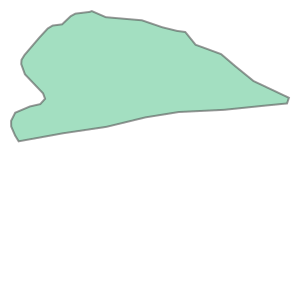

In [17]:
shape_o["geometry"][0]

In [ ]:
with rasterio.open(raster) as scr:
    for s in (range(len(shape_aumentado))):
        print(str(s)+" de "+str(len(shape_aumentado)))
        nombres=[]
        result=pd.DataFrame()
        casas=[]
        terreno=[]
        angulosget=[]
        conf_casas=[]
        conf_terreno=[]
        clase_casas=[]
        clase_terreno=[]
        shapes=[shape_aumentado['geometry'][s]]
        manzana,out_transform = rasterio.mask.mask(scr, shapes, crop=True)
        out_meta = scr.meta
        out_meta.update({'driver': 'GTiff',
        'height': manzana.shape[1],
        'width': manzana.shape[2],
        'transform': out_transform})
        output_file = r'D:/neza/manzana.tif'#+str(shape['cve_cat'][s])+'.tif'
        with rasterio.open(output_file, 'w', **out_meta) as dest:
            dest.write(manzana)
        cve_cat=shape["cve_cat"][s]
        print(cve_cat)
        alto,ancho,dim,crs,H,W,minx,maxx,miny,maxy=Parametro_raster(r"D:\neza\manzana.tif",metros=80)
        postproceso(Modelo,model_class,casas,conf_casas,clase_casas,terreno,conf_terreno,clase_terreno,raster,ancho,alto,dim,minx,maxx,miny,maxy,shape,angulo_get=0,opt_conf_thres=0.1,imshow=False,imsave=False,path="C:/Users/ASUS/salida/imagen")
#         postproceso(raster,ancho,alto,dim,angulo_get=shape['angulo_manzana'][s],opt_conf_thres=0.05)
        polygon=shape_o[shape_o['cve_cat']==cve_cat]["geometry"].values[0]
        gdf_casas=gpd.GeoDataFrame({'conf':conf_casas},geometry=casas,crs=scr.crs)
        gdf_casas.set_crs=scr.crs
        gdf_casas['area']=gdf_casas.area
        gdf_casas=gdf_casas.astype({'conf':'float64'})
        gdf_casas["cve_cat"]=cve_cat
        indices=[]
        for i,point in enumerate(gdf_casas["geometry"].centroid):
            if polygon.contains(point)==True:
                indices.append(i)
        gdf_casas=gdf_casas.iloc[indices].reset_index(drop=True)
        gdf_casas["centroid_x"]=[int(x/18) for x in gdf_casas.centroid.x]
        gdf_casas["centroid_y"]=[int(y/18) for y in gdf_casas.centroid.y]
        gdf_casas=gdf_casas.sort_values(by="conf",ascending=False).drop_duplicates(["centroid_x","centroid_y"],keep="first")
        if s==0:
            gdf_casas.to_file(r'C:/Users/ASUS/salida/shape/neza222_new_casas.shp')
        else:
            
            gdf_casas.to_file(r'C:/Users/ASUS/salida/shape/neza222_new_casas.shp',mode="a")
        gdf_terreno=gpd.GeoDataFrame({'conf':conf_terreno},geometry=terreno,crs=scr.crs)
        gdf_terreno.set_crs=scr.crs
        indices=[]
        for i,point in enumerate(gdf_terreno["geometry"].centroid):
            if polygon.contains(point)==True:
                indices.append(i)
        gdf_terreno=gdf_terreno.iloc[indices].reset_index(drop=True)
        gdf_terreno["centroid_x"]=[int(x/5) for x in gdf_terreno.centroid.x]
        gdf_terreno["centroid_y"]=[int(y/5) for y in gdf_terreno.centroid.y]
        gdf_terreno=gdf_terreno.sort_values(by="conf",ascending=False).drop_duplicates(["centroid_x","centroid_y"],keep="first")
        if s==0:
            gdf_terreno.to_file(r'C:/Users/ASUS/salida/shape/neza222_new_terreno.shp')
        else:
            gdf_terreno.to_file(r'C:/Users/ASUS/salida/shape/neza222_new_terreno.shp',mode="a")

## Generar imagenes mosaico

In [ ]:
# Path donde se guardan images
path_mosaico_salida=r"D:\instream\Mi unidad\geoshaps\neza\images/"
generar_imagenes=int(input("Generar imagenes: 1 si, 0 no "))
if generar_imagenes==1:
    generar_imagenes_sinrotar=int(input("Generar imagenes sin rotar: 1 si, 0 no "))
    generar_imagenes_rotadas=int(input("Generar imagenes rotadas: 1 si, 0 no "))
    with tqdm.tqdm(total=alto*ancho) as pbar:
        for j in range(0,ancho):#ancho
            for i in (range(alto)):#alto
                generar=0
                label=raster.replace("\\","/").split("/")[-1][:-4]+"_"
                nameimg=label.lower()+str(i)+"_"+str(j)
                cuadro=[]
                for k in range(2):
                    for l in range(2):
                        cuadro.append((minx+(maxx-minx)/ancho*(j+k),
                                       maxy-(maxy-miny)/alto*(i+l),
                                       0.0))
                cuadro=[cuadro[0],cuadro[1],cuadro[3],cuadro[2],cuadro[0]]
                for punto in cuadro:
                    x=float(punto[0])
                    y=float(punto[1])
                    if len(shape[(shape[0]<=x)&(shape[2]>=x)&(shape[1]<=y)&(shape[3]>=y)])>0:
                        generar=1             
                if generar==1:
                    shapes=[{"type":'Polygon','coordinates':[cuadro]}]
                    array, out_transform = rasterio.mask.mask(src, shapes, crop=True)
                    four_images=[array[2],array[1],array[0]]
                    imagen_n = np.stack(four_images, axis=-1)
                    if generar_imagenes_sinrotar==1:
                        cv2.imwrite(path_mosaico_salida+nameimg+".png",imagen_n)
                    if generar_imagenes_rotadas==1:
                        angulo_1,imagen_ro=correct_orientation(imagen_n,dim)
                        cv2.imwrite(path_mosaico_salida+nameimg+"_"+str(angulo_1)+".png",imagen_ro)
                pbar.update(1)

## Generar prediccion sobre imagen con salida txt

In [ ]:
path_mosaico_salida=r"C:\Users\ASUS\Inteligencia_Artificial\yolov7\train\imagess"
vector=Modelo.detect(opt_source=path_mosaico_salida,opt_conf_thres=0.3)
Generar_txt(vector,path_mosaico_salida+"labels")
with open(path_mosaico_salida+"labels/classes.txt","w") as f:
    f.writelines("\n".join(["casa","terreno_baldio"]))

In [ ]:
import glob 
filenames=glob.glob("train/images/*")
# for file in filenames:


In [ ]:
for i in tqdm.tqdm(range(3476,len(filenames))):
    file=filenames[i]
    imagen_n=cv2.imread(file)
    # assert imagen_n is not None,  "file could not be read, check with os.path.exists()"
    try:
        imagen_n=cv2.resize(imagen_n,(256,256))
    except:
        continue
    dim=imagen_n.shape[0]
    angulo=correct_orientation(imagen_n,dim=dim)[0]
    image_ro=imagen_n.copy()
    image_ro=rotate_image(image_ro,angulo,reshape=True)
    image_ro=cv2.resize(image_ro,(256,256))
    cv2.imwrite(file.replace("images","imagess"),image_ro)


In [ ]:
## shape igecem de manzanas por municipio (solo pora tener la delimitacion geografica del municipio)
shape=gpd.read_file(r"C:\Users\ASUS\Documents\GobiernoEdomex\Agua\geoshapes\Full manzanas\Manzana_Naucalpan.shp")
shape=shape.to_crs("3857")
c=[]
for manzana in range(len(shape)):
    proyecciones1=mapping(shape["geometry"][manzana]).get("coordinates")
    if len(proyecciones1)>1:
        for manzan in proyecciones1:
            print(manzana)
            try:
                proyecciones=manzan
            except:
                proyecciones=manzan[0]
            point1=np.min((proyecciones,proyecciones),axis=1)[0]
            min_y,min_x=point1[0],point1[1]
            point2=np.max((proyecciones,proyecciones),axis=1)[0]
            max_y,max_x=point2[0],point2[1]
            c.append(",".join([str(min_y),str(min_x),str(max_y),str(max_x)]))#,proyecciones
    else:
        proyecciones=proyecciones1[0]
        point1=np.min((proyecciones,proyecciones),axis=1)[0]
        min_y,min_x=point1[0],point1[1]
        point2=np.max((proyecciones,proyecciones),axis=1)[0]
        max_y,max_x=point2[0],point2[1]
        c.append(",".join([str(min_y),str(min_x),str(max_y),str(max_x)]))#,proyecciones    
    
    # point1=np.min((proyecciones,proyecciones),axis=1)[0]
    # min_y,min_x=point1[0],point1[1]
    # point2=np.max((proyecciones,proyecciones),axis=1)[0]
    # max_y,max_x=point2[0],point2[1]
    # c.append(",".join([str(min_y),str(min_x),str(max_y),str(max_x)]))#,proyecciones
shape1=pd.DataFrame()
shape1["points"]=c
shape1=shape1["points"].str.split(",",expand=True)
shape1=shape1.astype({0:"float64",1:"float64",2:"float64",3:"float64"})
shape=shape1
shape

In [ ]:
from shapely.geometry import Point
geo=[]
shape=gpd.read_file(r"C:\Users\ASUS\Documents\GobiernoEdomex\Agua\geoshapes\Full manzanas\Manzana_Naucalpan.shp")
shape=shape.to_crs("3857")
c=[]
for manzana in range(len(shape)):
    proyecciones1=mapping(shape["geometry"][manzana]).get("coordinates")
    for i in proyecciones1[0]:
        geo.append(Point(i))
sa=gpd.GeoDataFrame(geometry=geo)
sa

In [ ]:
sa.to_file(r"C:\Users\ASUS\Desktop\nau\pointnau.shp")

In [ ]:
gpd.sjoin(shape,shape1 , how='left', op='intersects').to_file(r"C:\Users\ASUS\Desktop\nau\sol.shp")

In [ ]:
shape1=gpd.read_file(r"C:\Users\ASUS\Desktop\nau\new_terreno1.shp")z
shape1

In [ ]:
indices=[]
for i,pol in enumerate(shape1["geometry"]):
    generar=0
    cuadro=mapping(pol).get("coordinates")[0]
    for punto in cuadro:
            x=float(punto[0])
            y=float(punto[1])
            if len(shape[(shape[0]<=x)&(shape[2]>=x)&(shape[1]<=y)&(shape[3]>=y)])>0:
                generar=1             
    if generar==1:
         indices.append(i)
indices

In [ ]:
shape1.loc[indices].to_file(r"C:\Users\ASUS\Desktop\nau/solo_naucalpan.shp")

In [ ]:
gpd.sjoin(shape,shape1 , how='inner', op='intersects').to_file(r"C:\Users\ASUS\Desktop\nau/sol.shp")

In [ ]:
complete_polys = [polygon for polygon in  if (polygon.centroid.x**2 + polygon.centroid.y**2 < 4**2)]

complete_polys

In [ ]:
import random
import rasterio
from rasterio.windows import Window

with rasterio.open(r"D:\haar\classes\carros.tif") as src:

    # The size in pixels of your desired window
    xsize, ysize = 1000,1000

    # Generate a random window origin (upper left) that ensures the window 
    # doesn't go outside the image. i.e. origin can only be between 
    # 0 and image width or height less the window width or height
    xmin, xmax = 0, src.width - xsize
    ymin, ymax = 0, src.height - ysize
    xoff, yoff = random.randint(xmin, xmax), random.randint(ymin, ymax)

    # Create a Window and calculate the transform from the source dataset    
    window = Window(0, 0, xsize, ysize)
    transform = src.window_transform(window)

    # Create a new cropped raster to write to
    profile = src.profile
    profile.update({
        'height': xsize,
        'width': ysize,
        'transform': transform})

    with rasterio.open('D:/haar/classes/carros_output.tif', 'w', **profile) as dst:
        # Read the data from the window and write it to the output raster
        dst.write(src.read(window=window))

In [ ]:
import geopandas as gpd
shape_o=gpd.read_file(r"D:\alexnet\carros.shp")
shape_o=shape_o.to_crs('3857')
# shape=shape_transform(shape_o.copy())
shape_aumentado=ampliar_shape(shape_o.copy())

In [ ]:
shape_aumentado.to_file(r"D:\alexnet\carros1.shp")

In [ ]:
import geopandas as gpd
import fiona
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping,Polygon
src_raster_path = r"C:\Users\ASUS\Desktop\presentacionyolov7\etiquetas_google1\neza.tif"
src=rasterio.open(src_raster_path)
H,W=src.shape
terrenos=gpd.read_file(r"C:\Users\ASUS\Desktop\presentacionyolov7\vero 2\vero\vero1.shp")
terrenos=terrenos.set_crs(3857)
terrenos=terrenos.to_crs(3857)
terrenos=ampliar_shape(terrenos,factor_ampliacion=1.25)
import tqdm
import cv2
for i,polygo in tqdm.tqdm(enumerate(terrenos["geometry"]),total=len(terrenos)):
    det="a"
    try:
        shapes=[mapping(polygo)]
    except:
        continue
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    array, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    four_images=[array[2],array[1],array[0]]
    stacked_images = np.stack(four_images, axis=-1)
    cv2.imwrite(r"D:\alexnet\train/"+terrenos.loc[i,"clase_dete"]+"4anew_"+str(i)+".png",stacked_images)
    # cv2.imshow("s",stacked_images)
    # k=cv2.waitKey(0) & 0xFF
    # if k==ord("a"):
    #     det="casa_"
    # elif k==ord("s"):
    #     det="carros_"
    # elif k==ord("d"):
    #     det="establecimiento_"
    # elif k==ord("f"):
    #     det="multivivienda_"
    # elif k==ord("g"):
    #     det="encontruccion_"
    # elif k==ord("h"):
    #     det="terreno_"
    # elif k<28:
    #     cv2.destroyAllWindows()
    #     break
    cv2.imwrite(r"D:\alexnet\train/"+terrenos.loc[i,"clase_dete"]+"4anew_"+str(i)+".png",stacked_images)
    cv2.destroyAllWindows()

In [ ]:
def ampliar_shape(shape,factor_ampliacion=2):
    """Amplifica el polygon de cada manzana con el fin de extrar imagenes sin perder informacion de la manzana"""
    shape["geometry"]=shape["geometry"]
    shape['centroid']=shape.centroid
    geometry=[]
    clase=[]
    for i,polygon in enumerate(shape['geometry']):
        try:
            point=mapping(shape['centroid'][i]).get('coordinates')
        except:
            continue
        x=point[0]
        y=point[1]
        go=[]
        coodinates=mapping(polygon).get('coordinates')[0]
        for a in coodinates:
            x1=a[0]
            y1=a[1]
            x2=x+(x1-x)*factor_ampliacion
            y2=y+(y1-y)*factor_ampliacion
            go.append((x2,y2))
        geometry.append(Polygon(go))
        clase.append(shape.loc[i,"clase_dete"])
    return gpd.GeoDataFrame({"clase_dete":clase},geometry=geometry)